# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import ast
import time

import gensim
from gensim.models import Word2Vec, Doc2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from scipy.sparse import save_npz


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import re

from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

# Configuration

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'processed_NEW.csv')
MODELS_DIR = os.path.join(BASE_DIR, 'models_saved', 'embeddings')
VISUALIZATIONS_DIR = os.path.join(BASE_DIR, 'visualizations', 'embeddings')
WORD2VEC_VISUALIZATION_DIR = os.path.join(VISUALIZATIONS_DIR, 'word2vec')
DOC2VEC_VISUALIZATION_DIR = os.path.join(VISUALIZATIONS_DIR, 'doc2vec')
ROBERT_VISUALIZATION_DIR = os.path.join(VISUALIZATIONS_DIR, 'robert')
TFIDF_VECTORS_PATH = os.path.join(MODELS_DIR, "tfidf_vectors.npz")
TFIDF_VECTORIZER_PATH = os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
os.makedirs(WORD2VEC_VISUALIZATION_DIR, exist_ok=True)
os.makedirs(DOC2VEC_VISUALIZATION_DIR, exist_ok=True)
os.makedirs(ROBERT_VISUALIZATION_DIR, exist_ok=True)

VECTOR_SIZE = 300
WINDOW_SIZE = 5   
MIN_COUNT = 5     
WORKERS = os.cpu_count() - 1

SKIP_GRAM_ALGORITHM = 1
CBOW_ALGORITHM = 0

PV_DM_ALGORITHM = 1
PV_DBOW_ALGORITHM = 0
W2V_EPOCHS = 10
D2V_EPOCHS = 20

# Load Processed Data

In [3]:
def parse_list_literal(x):
    try:
        if isinstance(x, list): return x
        return ast.literal_eval(x)
    except: 
        return []

In [4]:
print(f"--- Loading Processed Data ---")
try:
    converters = {
        'lemmas': parse_list_literal,
        'lemmas_filtered': parse_list_literal,
    }
    df_processed = pd.read_csv(PROCESSED_DATA_PATH, converters=converters)
    print(f"Processed data loaded successfully from: {PROCESSED_DATA_PATH}")
    print(f"Shape: {df_processed.shape}")

    if 'lemmas_filtered' not in df_processed.columns:
        raise ValueError("'lemmas_filtered' column not found.")
    if not isinstance(df_processed['lemmas_filtered'].iloc[0], list):
         print("Attempting conversion of 'lemmas_filtered' column...")
         df_processed['lemmas_filtered'] = df_processed['lemmas_filtered'].apply(parse_list_literal)
         if not isinstance(df_processed['lemmas_filtered'].iloc[0], list):
             raise TypeError("'lemmas_filtered' column could not be parsed as lists.")
    print("Verified 'lemmas_filtered' column.")

except Exception as e:
    print(f"Error loading or verifying processed data: {e}")
    df_processed = None

if df_processed is None:
    print("\nHalting execution due to data loading issues.")
    exit()

--- Loading Processed Data ---
Processed data loaded successfully from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\processed\processed_NEW.csv
Shape: (4334, 6)
Verified 'lemmas_filtered' column.


# Word2Vec Models

#### Initialize and Train Word2Vec Models

In [6]:
if df_processed is not None and 'lemmas_filtered' in df_processed.columns:
    print("\n--- Training Word2Vec Model ---")

    sentences = df_processed['lemmas_filtered'].tolist()
    sentences = [s for s in sentences if s]

    if not sentences:
        print("Error: No valid sentences found in 'lemmas_filtered' for Word2Vec training.")
    else:
        print(f"Training Word2Vec on {len(sentences)} documents...")
        start_time = time.time()

        w2v_300d_model = Word2Vec(sentences=sentences,
                                  vector_size=300,
                                  window=WINDOW_SIZE,
                                  min_count=MIN_COUNT,
                                  workers=WORKERS,
                                  sg=SKIP_GRAM_ALGORITHM,
                                  epochs=W2V_EPOCHS)
        
        w2v_150d_model = Word2Vec(sentences=sentences,
                                  vector_size=150,
                                  window=WINDOW_SIZE,
                                  min_count=MIN_COUNT,
                                  workers=WORKERS,
                                  sg=SKIP_GRAM_ALGORITHM,
                                  epochs=W2V_EPOCHS)

        end_time = time.time()
        print(f"Word2Vec training finished in {end_time - start_time:.2f} seconds.")

        w2v_300d_model_path = os.path.join(MODELS_DIR, f"word2vec_{300}d.model")
        w2v_150d_model_path = os.path.join(MODELS_DIR, f"word2vec_{150}d.model")
        try:
            w2v_300d_model.save(w2v_300d_model_path)
            w2v_150d_model.save(w2v_150d_model_path)
            print(f"Word2Vec 300d model saved to: {w2v_300d_model_path}")
            print(f"Word2Vec 150d model saved to: {w2v_150d_model_path}")
        except Exception as e:
            print(f"Error saving Word2Vec model: {e}")

        vocab_size = len(w2v_300d_model.wv.key_to_index)
        print(f"Vocabulary Size: {vocab_size}")
else:
    print("\nSkipping Word2Vec analysis because processed data is not available or 'lemmas_filtered' is missing.")


--- Training Word2Vec Model ---
Training Word2Vec on 4334 documents...
Word2Vec training finished in 21.03 seconds.
Word2Vec 300d model saved to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\word2vec_300d.model
Word2Vec 150d model saved to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\word2vec_150d.model

--- Word2Vec Neighbor Analysis ---
Vocabulary Size: 10771, 10771


#### Load Word2Vec Models

In [69]:
w2v_300d_model_filename = f"word2vec_{300}d.model"
w2v_300d_model_path = os.path.join(MODELS_DIR, w2v_300d_model_filename)
w2v_300d_model = None

w2v_150d_model_filename = f"word2vec_{150}d.model"
w2v_150d_model_path = os.path.join(MODELS_DIR, w2v_150d_model_filename)
w2v_150d_model = None

if os.path.exists(w2v_300d_model_path):
    print(f"Attempting to load existing Word2Vec 300d model from: {w2v_300d_model_path}")
    try:
        w2v_300d_model = Word2Vec.load(w2v_300d_model_path)
        print("Word2Vec 300d model loaded successfully")
        print(f"Vocabulary Size: {len(w2v_300d_model.wv.key_to_index)}")
    except Exception as e:
        print(f"Error loading Word2Vec 300d model from {w2v_300d_model_path}: {e}")
        print("Please ensure the model file is not corrupted and was saved correctly.")
        print("You might need to retrain the model if loading fails and you don't have a backup.")
else:
    print(f"Word2Vec 300d model file not found at: {w2v_300d_model_path}")
    print("Please ensure the path is correct, the model is saved, or run the training part of your notebook.")
    
if os.path.exists(w2v_150d_model_path):
    print(f"Attempting to load existing Word2Vec 150d model from: {w2v_150d_model_path}")
    try:
        w2v_150d_model = Word2Vec.load(w2v_150d_model_path)
        print("Word2Vec 150d model loaded successfully")
        print(f"Vocabulary Size: {len(w2v_150d_model.wv.key_to_index)}")
    except Exception as e:
        print(f"Error loading Word2Vec 150d model from {w2v_150d_model_path}: {e}")
        print("Please ensure the model file is not corrupted and was saved correctly.")
        print("You might need to retrain the model if loading fails and you don't have a backup.")
else:
    print(f"Word2Vec 150d model file not found at: {w2v_150d_model_path}")
    print("Please ensure the path is correct, the model is saved, or run the training part of your notebook.")

Attempting to load existing Word2Vec 300d model from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\word2vec_300d.model
Word2Vec 300d model loaded successfully
Vocabulary Size: 10771
Attempting to load existing Word2Vec 150d model from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\word2vec_150d.model
Word2Vec 150d model loaded successfully
Vocabulary Size: 10771


#### Visualize Word2Vec Neighbors of Target Word

In [6]:
def visualize_word_and_neighbors_tsne(model, target_word, top_n_neighbors=10, visualizations_dir="."):
    if model is None:
        print("Word2Vec model is not loaded. Cannot visualize neighbors.")
        return

    target_word_norm = target_word.lower()

    if target_word_norm not in model.wv:
        print(f"Target word '{target_word_norm}' not found in Word2Vec vocabulary.")
        return

    try:
        target_vector = model.wv[target_word_norm]
        words_to_plot = [target_word_norm]
        vectors_list = [target_vector]

        try:
            neighbors = model.wv.most_similar(target_word_norm, topn=top_n_neighbors)
        except KeyError:
            print(f"Could not retrieve neighbors for '{target_word_norm}'.")
            return
            
        print(f"Neighbors of '{target_word_norm}': {[(n, f'{s:.3f}') for n, s in neighbors]}")

        for neighbor_word, similarity_score in neighbors:
            if neighbor_word in model.wv:
                words_to_plot.append(neighbor_word)
                vectors_list.append(model.wv[neighbor_word])
            else:
                print(f"Neighbor '{neighbor_word}' (unexpectedly) not in vocab, skipping.")


        if len(vectors_list) <= 1:
            print("Not enough vectors (target + neighbors) to plot with t-SNE.")
            return

        word_vectors_np = np.array(vectors_list)

        perplexity_value = min(5, max(1, len(word_vectors_np) - 1))
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value,
                    n_iter=max(250, len(word_vectors_np) * 10),
                    init='pca', learning_rate='auto')
        
        print(f"Applying t-SNE to '{target_word_norm}' and its {len(vectors_list)-1} neighbors...")
        vectors_tsne = tsne.fit_transform(word_vectors_np)

        plt.figure(figsize=(10, 8))
        
        target_idx = words_to_plot.index(target_word_norm)
        
        plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], alpha=0.7, c='grey', label="Neighbors")
        plt.scatter(vectors_tsne[target_idx, 0], vectors_tsne[target_idx, 1],
                    alpha=1.0, c='red', s=100, label=f"Target: {target_word_norm}", edgecolors='black')

        for i, word in enumerate(words_to_plot):
            plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                         textcoords="offset points", xytext=(5,2), ha='right', fontsize=9)

        plt.title(f"t-SNE: '{target_word_norm}' and its Top {top_n_neighbors} Neighbors (Word2Vec {model.vector_size}d)")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        
        os.makedirs(visualizations_dir, exist_ok=True)
        
        plot_filename = f"tsne_word2vec_{target_word}_neighbors_{model.vector_size}.png"
        plot_path = os.path.join(visualizations_dir, plot_filename)
        
        plt.savefig(plot_path)
        print(f"t-SNE plot saved to: {plot_path}")
        plt.close()

    except Exception as e:
        print(f"Error during t-SNE visualization for '{target_word}': {e}")
        import traceback
        traceback.print_exc()

#### Visualize Word2Vec Neighbors Similarities from Emotion Word Clouds

In [ ]:
ANGER_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'anger')
ANTICIPATION_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'anticipation')
DISGUST_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'disgust')
FEAR_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'fear')
JOY_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'joy')
SADNESS_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'sadness')
SURPRISE_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'surprise')
TRUST_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'emotion', 'trust')


os.makedirs(ANGER_WORDS_DIR, exist_ok=True)
os.makedirs(ANTICIPATION_WORDS_DIR, exist_ok=True)
os.makedirs(DISGUST_WORDS_DIR, exist_ok=True)
os.makedirs(FEAR_WORDS_DIR, exist_ok=True)
os.makedirs(JOY_WORDS_DIR, exist_ok=True)
os.makedirs(SADNESS_WORDS_DIR, exist_ok=True)
os.makedirs(SURPRISE_WORDS_DIR, exist_ok=True)
os.makedirs(TRUST_WORDS_DIR, exist_ok=True)


ANGER_WORDS = ['război', 'conflict', 'politică', 'forță', 'luptă', 'atac', 'amenințare']
ANTICIPATION_WORDS = ['vrea', 'plan', 'ajunge', 'posibil', 'rezultat', 'timp', 'ordine']
DISGUST_WORDS = ['boală', 'epidemie', 'infecție', 'greu', 'bolnav', 'condamna', 'obliga']
FEAR_WORDS = ['problemă', 'militar', 'risc', 'periculos', 'pericol', 'deces', 'ilegal']
JOY_WORDS = ['liber', 'uniune', 'juca', 'petrece', 'bucura', 'promova', 'spectacol']
SADNESS_WORDS = ['afecta', 'pierde', 'moarte', 'izolare', 'deces', 'durere', 'victimă']
SURPRISE_WORDS = ['afla', 'descoperi', 'prezice', 'progres', 'coincidență', 'întâmplător', 'urgent']
TRUST_WORDS = ['guvern', 'sistem', 'oficial', 'comisie', 'sigur', 'susține', 'lege']

NUM_NEIGHBORS = 10

for target_word in ANGER_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=ANGER_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=ANGER_WORDS_DIR)
    
for target_word in ANTICIPATION_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=ANTICIPATION_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=ANTICIPATION_WORDS_DIR)

for target_word in DISGUST_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=DISGUST_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=DISGUST_WORDS_DIR)
    
for target_word in FEAR_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=FEAR_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=FEAR_WORDS_DIR)
    
for target_word in JOY_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=JOY_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=JOY_WORDS_DIR)
    
for target_word in SADNESS_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=SADNESS_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=SADNESS_WORDS_DIR)
    
for target_word in SURPRISE_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=SURPRISE_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=SURPRISE_WORDS_DIR)
    
for target_word in TRUST_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=TRUST_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=TRUST_WORDS_DIR)

#### Visualize Word2Vec Neighbours Similarities from Sentiment Word Clouds

In [ ]:
NEGATIVE_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'sentiment', 'negative_words')
POSITIVE_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'sentiment', 'positive_words')
NEUTRAL_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'sentiment', 'neutral_words')

os.makedirs(NEGATIVE_WORDS_DIR, exist_ok=True)
os.makedirs(POSITIVE_WORDS_DIR, exist_ok=True)
os.makedirs(NEUTRAL_WORDS_DIR, exist_ok=True)

NEGATIVE_WORDS = ['boală', 'război', 'risc', 'afecta', 'criză', 'deces', 'pierde']
POSITIVE_WORDS = ['medic', 'drept', 'copil', 'creștere', 'economie', 'putere', 'tehnologie']
NEUTRAL_WORDS = ['controla', 'recunoaște', 'stăpâni', 'evadare', 'variat', 'suporta', 'dor']

NUM_NEIGHBORS = 10

for target_word in NEGATIVE_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=NEGATIVE_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=NEGATIVE_WORDS_DIR)
    
for target_word in POSITIVE_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=POSITIVE_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=POSITIVE_WORDS_DIR)
    
for target_word in NEUTRAL_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=NEUTRAL_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=NEUTRAL_WORDS_DIR)

#### Visualize Word2Vec Neighbours Similarities from Category Word Clouds

In [ ]:
FAKE_NEWS_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'category', 'fake_news')
REAL_NEWS_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'category', 'real_news')
MISINFORMATION_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'category', 'misinformation')
PROPAGANDA_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'category', 'propaganda')
SATIRE_WORDS_DIR = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'category', 'satire')

os.makedirs(FAKE_NEWS_WORDS_DIR, exist_ok=True)
os.makedirs(REAL_NEWS_WORDS_DIR, exist_ok=True)
os.makedirs(MISINFORMATION_WORDS_DIR, exist_ok=True)
os.makedirs(PROPAGANDA_WORDS_DIR, exist_ok=True)
os.makedirs(SATIRE_WORDS_DIR, exist_ok=True)

FAKE_NEWS_WORDS = ['control']
REAL_NEWS_WORDS = ['decizie', 'minister']
MISINFORMATION_WORDS = ['digital', 'cibernetic', 'securitate']
PROPAGANDA_WORDS = ['studiu', 'efect']
SATIRE_WORDS = ['cip']

NUM_NEIGHBORS = 10

for target_word in FAKE_NEWS_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=FAKE_NEWS_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=FAKE_NEWS_WORDS_DIR)
    
for target_word in REAL_NEWS_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=REAL_NEWS_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=REAL_NEWS_WORDS_DIR)
    
for target_word in MISINFORMATION_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=MISINFORMATION_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=MISINFORMATION_WORDS_DIR)
    
for target_word in PROPAGANDA_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=PROPAGANDA_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=PROPAGANDA_WORDS_DIR)
    
for target_word in SATIRE_WORDS:
    visualize_word_and_neighbors_tsne(w2v_300d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=SATIRE_WORDS_DIR)
    visualize_word_and_neighbors_tsne(w2v_150d_model, target_word, top_n_neighbors=NUM_NEIGHBORS,
                                      visualizations_dir=SATIRE_WORDS_DIR)

#### Word2Vec Sentiment Word Cloud Analysis

In [ ]:
positive_word_cloud_words = ["creștere", "public", "potrivit", "putere", "medical", "drept", "masură", 'studiu']
negative_word_cloud_words = ["deces", "afecta", "risc", "boală", "problemă", "control", "război", "pierde"]
neutral_word_cloud_words = ["controla", "recunoaște", "divers", "dependent", "evadare", "stăpâni", "complicitate", "îndura"] 

word_lists_to_analyze = {
    "Positive": positive_word_cloud_words,
    "Negative": negative_word_cloud_words,
    "Neutral": neutral_word_cloud_words
}

if w2v_300d_model:
    print("\\n--- Word2Vec Sentiment Word Cloud Analysis ---")

    all_plot_vectors = []
    all_plot_labels = []
    all_plot_words = []

    for sentiment, word_list in word_lists_to_analyze.items():
        print(f"\\nProcessing {sentiment} words...")
        
        valid_words = [word for word in word_list if word in w2v_300d_model.wv]
        if not valid_words:
            print(f"No words from the {sentiment} list found in Word2Vec vocabulary. Skipping.")
            continue

        print(f"Found {len(valid_words)}/{len(word_list)} {sentiment} words in vocabulary: {valid_words}")
        word_vectors = np.array([w2v_300d_model.wv[word] for word in valid_words])
        
        all_plot_vectors.extend(word_vectors)
        all_plot_labels.extend([sentiment] * len(valid_words))
        all_plot_words.extend(valid_words)


    if all_plot_vectors:
        all_plot_vectors_np = np.array(all_plot_vectors)
        
        print("\\nApplying t-SNE for sentiment word categories...")
        perplexity_value = min(30, max(1, len(all_plot_vectors_np) - 1)) 
        
        if len(all_plot_vectors_np) > 1 :
            tsne_sentiment_words = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=1000)
            try:
                vectors_tsne = tsne_sentiment_words.fit_transform(all_plot_vectors_np)

                plt.figure(figsize=(12, 10))
                unique_sentiments = sorted(list(set(all_plot_labels)))
                palette = sns.color_palette("husl", len(unique_sentiments))
                sentiment_color_map = {sentiment: palette[i] for i, sentiment in enumerate(unique_sentiments)}

                for i, label in enumerate(all_plot_labels):
                    plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1],
                                color=sentiment_color_map[label],
                                label=label if i == all_plot_labels.index(label) else "", # Avoid duplicate labels in legend
                                alpha=0.8, s=100)
                    plt.annotate(all_plot_words[i],
                                 (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                                 textcoords="offset points",
                                 xytext=(5,2),
                                 ha='left',
                                 fontsize=9)

                plt.title('t-SNE Visualization of Sentiment Word Cloud Words (Word2Vec)')
                plt.xlabel("t-SNE Component 1")
                plt.ylabel("t-SNE Component 2")
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys(), title="Sentiment Category")
                plt.grid(True, linestyle='--', alpha=0.5)
                
                tsne_sentiment_w2v_path = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'tsne_word2vec_sentiment_clouds.png') #
                plt.savefig(tsne_sentiment_w2v_path)
                print(f"t-SNE plot for sentiment word clouds saved to: {tsne_sentiment_w2v_path}")
                plt.show()
                plt.close()

            except Exception as e:
                print(f"Error during t-SNE for sentiment words: {e}")
        else:
            print("Not enough data points (after filtering) to perform t-SNE visualization for sentiment word categories.")
            
    else:
        print("No valid words found across all sentiment categories to visualize.")
else:
    print("Word2Vec model (w2v_model) is not loaded. Cannot perform sentiment word cloud analysis.")

#### Word2Vec Emotion Word Cloud Analysis

In [ ]:
emotion_word_clouds = {
    "Joy": ["bine", "special", "uniune", "liber", "promova", "considera", "libertate"],
    "Sadness": ["afecta", "reduce", "final", "sfârșit", "scădere", "vină", "post"],
    "Anger": ["război", "lua", "face", "politică", "boală", "atac", "forță"],
    "Fear": ["caz", "pacient", "problemă", "nevoie", "risc", "muri", "pericol"],
    "Surprise": ["afla", "prezent", "rapid", "întâmpla", "descoperi", "găsi", "coincidență"],
    "Disgust": ["infecție", "bolnav", "bacterie", "contaminare", "dăunător", "autopsie", "eliminare"],
    "Trust": ["guvern", "comisie", "oficial", "bază", "autoritate", "sistem", "crede"],
    "Anticipation": ["timp", "public", "vrea", "rezultat", "posibil", "ajunge", "plan"]
}

if 'w2v_300d_model' in globals() and w2v_300d_model is not None:
    print("\\n--- Word2Vec Emotion Word Cloud Analysis ---")

    all_emotion_plot_vectors = []
    all_emotion_plot_labels = []
    all_emotion_plot_words = []

    for emotion_name, word_list in emotion_word_clouds.items():
        print(f"\\n--- Analyzing Emotion: {emotion_name} ---")
        
        valid_words_for_emotion = [word for word in word_list if word in w2v_300d_model.wv]
        
        if not valid_words_for_emotion:
            print(f"No words from the '{emotion_name}' list found in Word2Vec vocabulary. Skipping this emotion.")
            continue

        print(f"Found {len(valid_words_for_emotion)}/{len(word_list)} words for '{emotion_name}' in vocabulary: {valid_words_for_emotion}")
        
        if len(valid_words_for_emotion) > 1:
            similarities = []
            for i in range(len(valid_words_for_emotion)):
                for j in range(i + 1, len(valid_words_for_emotion)):
                    try:
                        sim = w2v_300d_model.wv.similarity(valid_words_for_emotion[i], valid_words_for_emotion[j])
                        similarities.append(sim)
                    except KeyError as e:
                        print(f"Warning: Could not calculate similarity involving a word from {e} - likely not in vocab (should have been filtered).")

            if similarities:
                avg_similarity = np.mean(similarities)
                print(f"Average pairwise cosine similarity for '{emotion_name}' words: {avg_similarity:.4f}")
        elif len(valid_words_for_emotion) == 1:
            print(f"Only one valid word for '{emotion_name}', cannot calculate pairwise similarity within the group.")

        print(f"Top neighbors for words associated with '{emotion_name}':")
        for word in valid_words_for_emotion:
            try:
                neighbors = w2v_300d_model.wv.most_similar(word, topn=5)
                neighbor_words = [n_word for n_word, n_sim in neighbors]
                print(f"  - Neighbors of '{word}': {neighbor_words}")
            except KeyError:
                print(f"  - Word '{word}' unexpectedly not in vocabulary for neighbor search.")
        
        emotion_word_vectors = np.array([w2v_300d_model.wv[word] for word in valid_words_for_emotion])
        all_emotion_plot_vectors.extend(emotion_word_vectors)
        all_emotion_plot_labels.extend([emotion_name] * len(valid_words_for_emotion))
        all_emotion_plot_words.extend(valid_words_for_emotion)

    if all_emotion_plot_vectors:
        all_emotion_plot_vectors_np = np.array(all_emotion_plot_vectors)
        
        print("\\n--- Applying t-SNE for All Emotion Word Categories ---")
        perplexity_value_emotion = min(30, max(1, len(all_emotion_plot_vectors_np) - 1))
        
        if len(all_emotion_plot_vectors_np) > 1:
            tsne_emotion_categories = TSNE(n_components=2, random_state=42, 
                                           perplexity=perplexity_value_emotion, n_iter=1000,
                                           init='pca', learning_rate='auto')
            try:
                emotion_vectors_tsne = tsne_emotion_categories.fit_transform(all_emotion_plot_vectors_np)

                plt.figure(figsize=(16, 12))
                unique_emotions = sorted(list(set(all_emotion_plot_labels)))
                
                if len(unique_emotions) <= 10:
                    palette_emotions = sns.color_palette("tab10", len(unique_emotions))
                else:
                    palette_emotions = sns.color_palette("husl", len(unique_emotions))

                emotion_color_map = {emotion: palette_emotions[i] for i, emotion in enumerate(unique_emotions)}

                for i, emotion_label in enumerate(all_emotion_plot_labels):
                    plt.scatter(emotion_vectors_tsne[i, 0], emotion_vectors_tsne[i, 1],
                                color=emotion_color_map[emotion_label],
                                label=emotion_label if i == all_emotion_plot_labels.index(emotion_label) else "",
                                alpha=0.8, s=100)
                    plt.annotate(all_emotion_plot_words[i],
                                 (emotion_vectors_tsne[i, 0], emotion_vectors_tsne[i, 1]),
                                 textcoords="offset points",
                                 xytext=(5,2),
                                 ha='right',
                                 fontsize=9)

                plt.title('t-SNE Visualization of Emotion Word Cloud Words (Word2Vec)')
                plt.xlabel("t-SNE Component 1")
                plt.ylabel("t-SNE Component 2")
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys(), title="Emotion Category", bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout(rect=[0, 0, 0.85, 1])
                plt.grid(True, linestyle='--', alpha=0.5)
                
                tsne_emotions_w2v_path = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'tsne_word2vec_emotion_clouds.png')
                plt.savefig(tsne_emotions_w2v_path)
                
                plt.close()

            except Exception as e:
                print(f"Error during t-SNE for emotion categories: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("Not enough data points (after filtering across all emotions) to perform t-SNE visualization.")
            
    else:
        print("No valid words found across all emotion categories to visualize.")
else:
    print("Word2Vec model (w2v_model) is not loaded. Cannot perform emotion word cloud analysis.")

#### Analyzing Word2Vec Similarity and Neighbours for Emotion-Specific Words

In [ ]:
emotion_word_clouds = {
    "Joy": ["bine", "special", "uniune", "liber", "promova", "considera", "libertate"],
    "Sadness": ["afecta", "reduce", "final", "sfârșit", "scădere", "vină", "post"],
    "Anger": ["război", "lua", "face", "politică", "boală", "atac", "forță"],
    "Fear": ["caz", "pacient", "problemă", "nevoie", "risc", "muri", "pericol"],
    "Surprise": ["afla", "prezent", "rapid", "întâmpla", "descoperi", "găsi", "coincidență"],
    "Disgust": ["infecție", "bolnav", "bacterie", "contaminare", "dăunător", "autopsie", "eliminare"],
    "Trust": ["guvern", "comisie", "oficial", "bază", "autoritate", "sistem", "crede"],
    "Anticipation": ["timp", "public", "vrea", "rezultat", "posibil", "ajunge", "plan"]
}

if 'w2v_300d_model' in globals() and w2v_300d_model is not None:
    print("\\n--- Word2Vec Emotion Word Cloud Analysis ---")

    all_emotion_plot_vectors = []
    all_emotion_plot_labels = []
    all_emotion_plot_words = []

    for emotion_name, word_list in emotion_word_clouds.items():
        print(f"\\n--- Analyzing Emotion: {emotion_name} ---")
        
        valid_words_for_emotion = [word for word in word_list if word in w2v_300d_model.wv]
        
        if not valid_words_for_emotion:
            print(f"No words from the '{emotion_name}' list found in Word2Vec vocabulary. Skipping this emotion.")
            continue

        print(f"Found {len(valid_words_for_emotion)}/{len(word_list)} words for '{emotion_name}' in vocabulary: {valid_words_for_emotion}")
        
        if len(valid_words_for_emotion) > 1:
            similarities = []
            for i in range(len(valid_words_for_emotion)):
                for j in range(i + 1, len(valid_words_for_emotion)):
                    try:
                        sim = w2v_300d_model.wv.similarity(valid_words_for_emotion[i], valid_words_for_emotion[j])
                        similarities.append(sim)
                    except KeyError as e:
                        print(f"Warning: Could not calculate similarity involving a word from {e} - likely not in vocab (should have been filtered).")

            if similarities:
                avg_similarity = np.mean(similarities)
                print(f"Average pairwise cosine similarity for '{emotion_name}' words: {avg_similarity:.4f}")
        elif len(valid_words_for_emotion) == 1:
            print(f"Only one valid word for '{emotion_name}', cannot calculate pairwise similarity within the group.")

        print(f"Top neighbors for words associated with '{emotion_name}':")
        for word in valid_words_for_emotion:
            try:
                neighbors = w2v_300d_model.wv.most_similar(word, topn=5)
                neighbor_words = [n_word for n_word, n_sim in neighbors]
                print(f"  - Neighbors of '{word}': {neighbor_words}")
            except KeyError:
                print(f"  - Word '{word}' unexpectedly not in vocabulary for neighbor search.")
        
        emotion_word_vectors = np.array([w2v_300d_model.wv[word] for word in valid_words_for_emotion])
        all_emotion_plot_vectors.extend(emotion_word_vectors)
        all_emotion_plot_labels.extend([emotion_name] * len(valid_words_for_emotion))
        all_emotion_plot_words.extend(valid_words_for_emotion)

    if all_emotion_plot_vectors:
        all_emotion_plot_vectors_np = np.array(all_emotion_plot_vectors)
        
        print("\\n--- Applying t-SNE for All Emotion Word Categories ---")
        perplexity_value_emotion = min(30, max(1, len(all_emotion_plot_vectors_np) - 1))
        
        if len(all_emotion_plot_vectors_np) > 1:
            tsne_emotion_categories = TSNE(n_components=2, random_state=42, 
                                           perplexity=perplexity_value_emotion, n_iter=1000,
                                           init='pca', learning_rate='auto')
            try:
                emotion_vectors_tsne = tsne_emotion_categories.fit_transform(all_emotion_plot_vectors_np)

                plt.figure(figsize=(16, 12))
                unique_emotions = sorted(list(set(all_emotion_plot_labels)))
                
                if len(unique_emotions) <= 10:
                    palette_emotions = sns.color_palette("tab10", len(unique_emotions))
                else:
                    palette_emotions = sns.color_palette("husl", len(unique_emotions))

                emotion_color_map = {emotion: palette_emotions[i] for i, emotion in enumerate(unique_emotions)}

                for i, emotion_label in enumerate(all_emotion_plot_labels):
                    plt.scatter(emotion_vectors_tsne[i, 0], emotion_vectors_tsne[i, 1],
                                color=emotion_color_map[emotion_label],
                                label=emotion_label if i == all_emotion_plot_labels.index(emotion_label) else "",
                                alpha=0.8, s=100)
                    plt.annotate(all_emotion_plot_words[i],
                                 (emotion_vectors_tsne[i, 0], emotion_vectors_tsne[i, 1]),
                                 textcoords="offset points",
                                 xytext=(5,2),
                                 ha='left',
                                 fontsize=9)

                plt.title('t-SNE Visualization of Emotion Word Cloud Words (Word2Vec)')
                plt.xlabel("t-SNE Component 1")
                plt.ylabel("t-SNE Component 2")
                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys(), title="Emotion Category", bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout(rect=[0, 0, 0.85, 1])
                plt.grid(True, linestyle='--', alpha=0.5)
                
                if 'WORD2VEC_VISUALIZATION_DIR' in globals():
                    tsne_emotions_w2v_path = os.path.join(WORD2VEC_VISUALIZATION_DIR, 'tsne_word2vec_emotion_clouds.png')
                    plt.savefig(tsne_emotions_w2v_path)
                    print(f"t-SNE plot for emotion categories saved to: {tsne_emotions_w2v_path}")
                else:
                    print("WORD2VEC_VISUALIZATION_DIR not defined. Cannot save plot.")
                
                plt.close()

            except Exception as e:
                print(f"Error during t-SNE for emotion categories: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("Not enough data points (after filtering across all emotions) to perform t-SNE visualization.")
            
    else:
        print("No valid words found across all emotion categories to visualize.")
else:
    print("Word2Vec model (w2v_300d_model) is not loaded. Cannot perform emotion word cloud analysis.")

#### Word2Vec Two Target Words Neighbors Analysis

In [42]:
def visualize_competing_word_clusters(model, word1, word2, top_n_neighbors=10, visualizations_dir="."):
    if model is None:
        print("Word2Vec model is not loaded. Cannot visualize clusters.")
        return

    word1_norm = word1.lower()
    word2_norm = word2.lower()

    all_words_to_plot = []
    all_vectors_list = []
    all_labels_list = []

    if word1_norm in model.wv:
        all_words_to_plot.append(word1_norm)
        all_vectors_list.append(model.wv[word1_norm])
        all_labels_list.append(f"Group: {word1_norm}")
        
        neighbors1 = model.wv.most_similar(word1_norm, topn=top_n_neighbors)
        for neighbor_word, _ in neighbors1:
            all_words_to_plot.append(neighbor_word)
            all_vectors_list.append(model.wv[neighbor_word])
            all_labels_list.append(f"Group: {word1_norm}")
        print(f"Found '{word1_norm}' and its {len(neighbors1)} neighbors.")
    else:
        print(f"Word '{word1_norm}' not found in vocabulary. Cannot create its cluster.")
        return

    if word2_norm in model.wv:
        all_words_to_plot.append(word2_norm)
        all_vectors_list.append(model.wv[word2_norm])
        all_labels_list.append(f"Group: {word2_norm}")

        neighbors2 = model.wv.most_similar(word2_norm, topn=top_n_neighbors)
        for neighbor_word, _ in neighbors2:
            if neighbor_word not in all_words_to_plot:
                all_words_to_plot.append(neighbor_word)
                all_vectors_list.append(model.wv[neighbor_word])
                all_labels_list.append(f"Group: {word2_norm}")
        print(f"Found '{word2_norm}' and its {len(neighbors2)} neighbors.")
    else:
        print(f"Word '{word2_norm}' not found in vocabulary. Cannot create its cluster.")
        return

    if len(all_vectors_list) <= 1:
        print("Not enough vectors to plot with t-SNE.")
        return

    word_vectors_np = np.array(all_vectors_list)
    perplexity_value = min(10, max(1, len(word_vectors_np) - 1))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value,
                n_iter=1000, init='pca', learning_rate='auto')
    
    print(f"Applying t-SNE to {len(all_words_to_plot)} words...")
    vectors_tsne = tsne.fit_transform(word_vectors_np)

    plt.figure(figsize=(14, 10))
    palette = sns.color_palette("deep", 2)

    for i, label in enumerate(all_labels_list):
        color = palette[0] if label == f"Group: {word1_norm}" else palette[1]
        plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1], c=[color], alpha=0.7)

    for i, word in enumerate(all_words_to_plot):
        plt.annotate(word, (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                     textcoords="offset points", xytext=(5,2), ha='left', fontsize=9)

    target1_idx = all_words_to_plot.index(word1_norm)
    target2_idx = all_words_to_plot.index(word2_norm)
    plt.scatter(vectors_tsne[target1_idx, 0], vectors_tsne[target1_idx, 1],
                c=[palette[0]], s=150, edgecolors='black', marker='*', label=f"Target: {word1_norm}")
    plt.scatter(vectors_tsne[target2_idx, 0], vectors_tsne[target2_idx, 1],
                c=[palette[1]], s=150, edgecolors='black', marker='*', label=f"Target: {word2_norm}")

    plt.title(f"t-SNE Comparison: '{word1_norm}' vs '{word2_norm}' Neighborhoods ({model.wv.vector_size}d Word2Vec Model)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    os.makedirs(visualizations_dir, exist_ok=True)
    filename = f"tsne_comparison_{word1_norm}_vs_{word2_norm}_{model.wv.vector_size}d.png"
    plot_path = os.path.join(visualizations_dir, filename)
    
    plt.savefig(plot_path)
    print(f"Comparison t-SNE plot saved to: {plot_path}")
    plt.close()

In [ ]:
word_positive_or_real = "adevăr"
word_negative_or_fake = "fals"

if 'w2v_300d_model' in globals() and w2v_300d_model is not None and 'WORD2VEC_VISUALIZATION_DIR' in globals():
    visualize_competing_word_clusters(
        w2v_300d_model,
        word_positive_or_real,
        word_negative_or_fake,
        top_n_neighbors=8,
        visualizations_dir=WORD2VEC_VISUALIZATION_DIR
    )
else:
    print("Please ensure 'w2v_model' is loaded and 'VISUALIZATIONS_DIR' is defined.")

#### Word2Vec Contextual Bias Analysis 

##### Load Pretrained Corola Model

In [ ]:
pretrained_model_path = os.path.join(MODELS_DIR, 'corola.300.20.vec')
if os.path.exists(pretrained_model_path):
    print(f"Loading pretrained Word2Vec model from: {pretrained_model_path}")
    try:
        general_romanian_model = KeyedVectors.load_word2vec_format(pretrained_model_path, binary=False)
        print("Pretrained Word2Vec model loaded successfully.")
        print(f"Vocabulary Size: {len(general_romanian_model.key_to_index)}")
    except Exception as e:
        print(f"Error loading pretrained Word2Vec model: {e}")
else:
    print(f"Pretrained Word2Vec model not found at: {pretrained_model_path}")
    w2v_pretrained_model = None

In [35]:
def compare_word_neighbors(target_word, model1, model1_name, model2, model2_name, top_n=10):
    target_word_norm = target_word.lower()
    print("\\n" + "="*50)
    print(f"Comparing neighbors for target word: '{target_word_norm}'")
    print("="*50)

    neighbors1 = []
    if model1 and target_word_norm in model1.wv:
        neighbors1 = [word for word, sim in model1.wv.most_similar(target_word_norm, topn=top_n)]
    elif not model1:
        neighbors1 = ["Model not loaded."]
    else:
        neighbors1 = ["Word not in vocabulary."]

    neighbors2 = []
    if model2 and target_word_norm in model2:
        neighbors2 = [word for word, sim in model2.most_similar(target_word_norm, topn=top_n)]
    elif not model2:
        neighbors2 = ["Model not loaded."]
    else:
        neighbors2 = ["Word not in vocabulary."]
    
    print(f"{model1_name.ljust(30)} | {model2_name.ljust(30)}")
    print("-"*63)
    
    max_rows = max(len(neighbors1), len(neighbors2))
    for i in range(max_rows):
        n1 = neighbors1[i] if i < len(neighbors1) else ""
        n2 = neighbors2[i] if i < len(neighbors2) else ""
        print(f"{n1.ljust(30)} | {n2.ljust(30)}")

In [ ]:
target_word_to_compare = "vaccin" 

if w2v_300d_model and general_romanian_model:
    compare_word_neighbors(
        target_word_to_compare,
        w2v_300d_model, "Fake News Model",
        general_romanian_model, "General Romanian Model",
        top_n=10
    )
    
    compare_word_neighbors("expert", w2v_300d_model, "Fake News Model", general_romanian_model, "General Romanian Model")
    compare_word_neighbors("sistem", w2v_300d_model, "Fake News Model", general_romanian_model, "General Romanian Model")
    compare_word_neighbors("mainstream", w2v_300d_model, "Fake News Model", general_romanian_model, "General Romanian Model")
    compare_word_neighbors("guvern", w2v_300d_model, "Fake News Model", general_romanian_model, "General Romanian Model")
else:
    print("\\nCannot run analysis because one or both models failed to load.")

# Doc2Vec Models

#### Prepare TaggedDocument Input

In [ ]:
try:
    if not df_processed.index.is_unique:
        print("Warning: DataFrame index is not unique. Resetting index...")
        df_processed.reset_index(drop=True, inplace=True)

    tagged_data = [TaggedDocument(words=doc, tags=[i])
                   for i, doc in enumerate(df_processed['lemmas_filtered']) if isinstance(doc, list) and doc]

    if not tagged_data:
         raise ValueError("No valid TaggedDocuments could be created. Check 'lemmas_filtered' content.")

    print(f"Created {len(tagged_data)} TaggedDocuments for Doc2Vec training.")
except Exception as e:
    print(f"Error creating TaggedDocuments: {e}")
    tagged_data = None

#### Initialize and Train Doc2Vec Models

In [ ]:
print("\n--- Training Doc2Vec Model ---")

if tagged_data:
    print("Initializing Doc2Vec model (PV-DM)...")
    d2v_300d_model = Doc2Vec(vector_size=300,
                             window=WINDOW_SIZE,
                             min_count=MIN_COUNT,
                             workers=WORKERS,
                             dm=PV_DM_ALGORITHM,
                             epochs=D2V_EPOCHS)
    
    d2v_150d_model = Doc2Vec(vector_size=150,
                             window=WINDOW_SIZE,
                             min_count=MIN_COUNT,
                             workers=WORKERS,
                             dm=PV_DM_ALGORITHM,
                             epochs=D2V_EPOCHS)

    print("Building Doc2Vec vocabulary for models...")
    start_time = time.time()
    d2v_300d_model.build_vocab(tagged_data)
    d2v_150d_model.build_vocab(tagged_data)
    vocab_time = time.time()
    print(f"Vocabulary built in {vocab_time - start_time:.2f} seconds. Vocab size: {len(d2v_300d_model.wv.key_to_index)}")

    print(f"Training Doc2Vec 300d model for {D2V_EPOCHS} epochs...")
    d2v_300d_model.train(tagged_data, total_examples=d2v_300d_model.corpus_count, epochs=d2v_300d_model.epochs)
    train_time_300d = time.time()
    print(f"Doc2Vec training finished in {train_time_300d - vocab_time:.2f} seconds.")
    
    print(f"Training Doc2Vec 150d model for {D2V_EPOCHS} epochs...")
    d2v_300d_model.train(tagged_data, total_examples=d2v_150d_model.corpus_count, epochs=d2v_150d_model.epochs)
    train_time_150d = time.time()
    print(f"Doc2Vec training finished in {train_time_150d - train_time_300d:.2f} seconds.")


    d2v_300d_model_path = os.path.join(MODELS_DIR, f"doc2vec_{300}d.model")
    d2v_150d_model_path = os.path.join(MODELS_DIR, f"doc2vec_{150}d.model")
    try:
        d2v_300d_model.save(d2v_300d_model_path)
        d2v_150d_model.save(d2v_150d_model_path)
        print(f"Doc2Vec 300d model saved to: {d2v_300d_model_path}")
        print(f"Doc2Vec 150d model saved to: {d2v_150d_model_path}")
    except Exception as e:
        print(f"Error saving Doc2Vec models: {e}")
else:
    print("\nSkipping Doc2Vec training and analysis because TaggedDocument creation failed.")

#### Load Doc2Vec Models

In [ ]:
d2v_300d_model_filename = f"doc2vec_{300}d.model"
d2v_300d_model_path = os.path.join(MODELS_DIR, d2v_300d_model_filename)
d2v_300d_model = None

d2v_150d_model_filename = f"doc2vec_{150}d.model"
d2v_150d_model_path = os.path.join(MODELS_DIR, d2v_150d_model_filename)
d2v_150d_model = None 

if os.path.exists(d2v_300d_model_path):
    print(f"Attempting to load existing Doc2Vec 300d model from: {d2v_300d_model_path}")
    try:
        d2v_300d_model = Doc2Vec.load(d2v_300d_model_path)
        print("Doc2Vec 300d model loaded successfully")
        print(f"Vocabulary Size: {len(d2v_300d_model.wv.key_to_index)}")
    except Exception as e:
        print(f"Error loading Doc2Vec 300d model from {d2v_300d_model_path}: {e}")
        print("Please ensure the model file is not corrupted and was saved correctly.")
        print("You might need to retrain the model if loading fails and you don't have a backup.")
else:
    print(f"Doc2Vec 300d model file not found at: {d2v_300d_model_path}")
    print("Please ensure the path is correct, the model is saved, or run the training part of your notebook.")
    
if os.path.exists(d2v_150d_model_path):
    print(f"Attempting to load existing Doc2Vec 150d model from: {d2v_150d_model_path}")
    try:
        d2v_150d_model = Doc2Vec.load(d2v_150d_model_path)
        print("Doc2Vec 150d model loaded successfully")
        print(f"Vocabulary Size: {len(d2v_150d_model.wv.key_to_index)}")
    except Exception as e:
        print(f"Error loading Doc2Vec 150d model from {d2v_150d_model_path}: {e}")
else:
    print(f"Doc2Vec 150d model file not found at: {d2v_150d_model_path}")

#### Visualize Doc2Vec Embeddings

In [36]:
def visualize_doc2vec_tsne(d2v_model, plot_context_name, df_to_visualize, visualizations_dir):
    print(f"\\n--- Visualizing Doc2Vec Embeddings (Context: {plot_context_name}D) with t-SNE ---")

    if d2v_model is None:
        print("Error: Doc2Vec model is None. Cannot visualize.")
        return
    if not hasattr(d2v_model, 'dv') or len(d2v_model.dv) == 0:
        print("Doc2Vec model has no document vectors (model.dv is empty or missing). Skipping visualization.")
        return
    if df_to_visualize is None or df_to_visualize.empty:
        print(f"Error: DataFrame for visualization ('{plot_context_name}') is None or empty. Cannot visualize.")
        return
    if 'tag' not in df_to_visualize.columns:
        print(f"Error: 'tag' column not found in the DataFrame for '{plot_context_name}'. Cannot get labels.")
        return

    print(f"Processing {len(df_to_visualize)} documents from the provided DataFrame for context '{plot_context_name}'.")

    num_docs = len(d2v_model.dv)
    
    if num_docs == 0:
        print("Doc2Vec model has no document vectors (model.dv is empty). Skipping t-SNE visualization.")
        return
    
    doc_vectors_list = []
    doc_labels_list = []
    
    for original_idx, row_data in df_to_visualize.iterrows():
        if original_idx in d2v_model.dv:  # if model has a vector for this original index/tag
            doc_vectors_list.append(d2v_model.dv[original_idx])
            doc_labels_list.append(row_data['tag'])
        else:
            print(f"Warning: Original index {original_idx} (from DataFrame for '{plot_context_name}') "
                  f"not found in Doc2Vec model's document vectors (model.dv). Skipping this document.")
    
    if not doc_vectors_list:
        print(f"No valid document vectors could be extracted for the context '{plot_context_name}'. Skipping t-SNE.")
        return

    doc_vectors = np.array(doc_vectors_list)
    doc_labels = np.array(doc_labels_list)

    if doc_vectors.size == 0:
        print("No document vectors could be extracted for plotting. Skipping t-SNE visualization.")
        return

    print(f"Applying t-SNE to {len(doc_vectors)} document vectors...")
    perplexity_value = min(30, max(1, len(doc_vectors) -1)) 
    tsne_d2v = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, 
                    n_iter=1000, init='pca', learning_rate='auto')

    try:
        vectors_d2v_tsne = tsne_d2v.fit_transform(doc_vectors)

        plt.figure(figsize=(12, 9))
        
        categories = df_to_visualize['tag'].unique()
        
        if len(categories) == 0:
            print(f"No unique categories found in the labels for plotting context '{plot_context_name}'. Skipping scatter plot.")
            plt.close()
            return
        
        colors = sns.color_palette("tab10", len(categories))
        category_color_map = {category: color for category, color in zip(categories, colors)}

        for category in categories:
            indices = np.where(doc_labels == category)[0]
            if len(indices) > 0:
                plt.scatter(vectors_d2v_tsne[indices, 0], 
                            vectors_d2v_tsne[indices, 1],
                            c=[category_color_map[category]],
                            label=category,
                            marker='.', alpha=0.7)

        plt.title(f't-SNE Visualization of Doc2Vec Document Embeddings ({plot_context_name}D)')
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.legend(title='News Category', loc='best', markerscale=2)
        plt.grid(True, linestyle='--', alpha=0.5)
        
        os.makedirs(visualizations_dir, exist_ok=True)
        
        tsne_d2v_filename = f'tsne_doc2vec_{plot_context_name}d.png'
        tsne_d2v_path = os.path.join(visualizations_dir, tsne_d2v_filename)
        plt.savefig(tsne_d2v_path)
        print(f"t-SNE plot for Doc2Vec context ({plot_context_name}) saved to: {tsne_d2v_path}")
        plt.close()

    except Exception as e:
        print(f"Error during t-SNE fitting or plotting for Doc2Vec ({plot_context_name}d): {e}")
        import traceback
        traceback.print_exc()

#### Visualize Doc2Vec Embeddings of All Artiles

In [ ]:
visualize_doc2vec_tsne(d2v_300d_model, 300, df_processed, DOC2VEC_VISUALIZATION_DIR)
visualize_doc2vec_tsne(d2v_150d_model, 150, df_processed, DOC2VEC_VISUALIZATION_DIR)

#### Doc2Vec 300D Real vs Fake

In [ ]:
TAGS_FAKE_VS_REAL = ['real_news', 'fake_news']

df_fake_vs_real = df_processed[df_processed['tag'].isin(TAGS_FAKE_VS_REAL)].copy()

if not df_fake_vs_real.empty:
    visualize_doc2vec_tsne(
        d2v_model=d2v_300d_model,
        plot_context_name=f"fake_vs_real_{300}",
        df_to_visualize=df_fake_vs_real,
        visualizations_dir=DOC2VEC_VISUALIZATION_DIR
    )
else:
    print(f"No data found for tags: {TAGS_FAKE_VS_REAL}. Skipping 'Fake vs Real' plot.")


#### Doc2Vec 300D Fake vs Misinformation vs Propaganda 

In [ ]:
TAGS_FAKE_MISINFO_PROP = ['fake_news', 'misinformation', 'propaganda']

df_fake_misinformation = df_processed[df_processed['tag'].isin(TAGS_FAKE_MISINFO_PROP)].copy()

if not df_fake_misinformation.empty:
    visualize_doc2vec_tsne(
        d2v_model=d2v_300d_model,
        plot_context_name=f"fake_misinformation_propaganda_{300}",
        df_to_visualize=df_fake_misinformation,
        visualizations_dir=DOC2VEC_VISUALIZATION_DIR
    )
else:
    print(f"No data found for tags: {TAGS_FAKE_MISINFO_PROP}. Skipping 'Fake vs Misinformation' plot.")

# RoBERT

#### Configuration

In [5]:
MODEL_NAME = "readerbench/RoBERT-base"

ROBERT_EMBEDDINGS_PATH = os.path.join(MODELS_DIR, "robert_cls_embeddings.npy")
ROBERT_EMBEDDING_DIM = 768

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"RoBERT model name: {MODEL_NAME}")
print(f"Embeddings will be saved to: {ROBERT_EMBEDDINGS_PATH}")

Using device: cpu
RoBERT model name: readerbench/RoBERT-base
Embeddings will be saved to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\robert_cls_embeddings.npy


#### Load Model and Tokenizer

In [6]:
try:
    print(f"Loading tokenizer for '{MODEL_NAME}'...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    print(f"Loading model '{MODEL_NAME}'...")
    model = AutoModel.from_pretrained(MODEL_NAME)
    
    model.to(DEVICE)
    
    model.eval()
    
    print("Model and tokenizer loaded successfully.")

except Exception as e:
    print(f"Error loading model or tokenizer: {e}")
    model = None

Loading tokenizer for 'readerbench/RoBERT-base'...
Loading model 'readerbench/RoBERT-base'...
Model and tokenizer loaded successfully.


#### Extract CLS Embeddings

In [22]:
def get_robert_cls_embeddings(texts, model, tokenizer, device, batch_size=16):
    all_cls_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting RoBERT Embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch_texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_cls_embeddings.append(cls_embeddings)
        
    return np.vstack(all_cls_embeddings)

In [23]:
if 'model' in globals() and model is not None:
    try:
        print(f"Loading processed data from: {PROCESSED_DATA_PATH}")
        df = pd.read_csv(PROCESSED_DATA_PATH)

        if 'content' in df.columns and not df['content'].isnull().all():
            documents = df['content'].tolist()
            
            print(f"Found {len(documents)} documents to process.")

            robert_embeddings = get_robert_cls_embeddings(
                texts=documents,
                model=model,
                tokenizer=tokenizer,
                device=DEVICE
            )
            
            print(f"Successfully generated embeddings. Shape: {robert_embeddings.shape}")

            print(f"Saving embeddings to {ROBERT_EMBEDDINGS_PATH}...")
            np.save(ROBERT_EMBEDDINGS_PATH, robert_embeddings)
            print("Embeddings saved successfully.")

        else:
            print("Error: 'content' column not found or is empty in the processed data file.")

    except FileNotFoundError:
        print(f"Error: Processed data file not found at {PROCESSED_DATA_PATH}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
    print("RoBERT model not loaded. Please run Cell 2 successfully before this one.")

Loading processed data from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\processed\processed_NEW.csv
Found 4334 documents to process.


Extracting RoBERTa Embeddings:   0%|          | 0/271 [00:00<?, ?it/s]

Successfully generated embeddings. Shape: (4334, 768)
Saving embeddings to C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\roberta_cls_embeddings.npy...
Embeddings saved successfully.


#### Different Contexts of Target Word Based on Category Analysis

In [7]:
TARGET_WORD = "vaccin"
article_examples = {}
categories_to_find = ['real_news', 'fake_news', 'satire']

for category in categories_to_find:
    df_subset = df_processed[
        (df_processed['tag'] == category) & 
        (df_processed['content'].str.contains(f'\\b{TARGET_WORD}\\b', case=False, regex=True))
    ]
    
    if not df_subset.empty:
        found_index = df_subset.index[0]
        article_examples[category] = found_index
        print(f"Found '{TARGET_WORD}' in a '{category}' article at index: {found_index}")
    else:
        print(f"Warning: Could not find an article containing '{TARGET_WORD}' for category '{category}'.")

print(f"\nSelected article examples for analysis: {article_examples}")

Found 'vaccin' in a 'real_news' article at index: 986
Found 'vaccin' in a 'fake_news' article at index: 81
Found 'vaccin' in a 'satire' article at index: 1295

Selected article examples for analysis: {'real_news': 986, 'fake_news': 81, 'satire': 1295}


In [8]:
def get_robert_word_embeddings_in_context(text, target_lemma, tokenizer, model, device, embedding_dim):
    instance_embeddings = []
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
        
        try:
            word_ids_list = inputs.word_ids(batch_index=0)
        except Exception as e:
            print(f"Warning: tokenizer.word_ids() failed: {e}. Cannot reliably extract word embeddings for this text.")
            return instance_embeddings

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state[0].cpu()


        unique_indices = set()
        for word_id in word_ids_list:
            if word_id is not None:
                unique_indices.add(word_id)
        unique_word_indices_in_doc = sorted(list(unique_indices))

        for word_idx_in_doc in unique_word_indices_in_doc:
            current_word_token_indices = [i for i, w_id in enumerate(word_ids_list) if w_id == word_idx_in_doc]
            
            if not current_word_token_indices:
                continue

            original_token_ids_for_word = inputs['input_ids'][0, current_word_token_indices].cpu().tolist()
            word_text_reconstructed = tokenizer.decode(original_token_ids_for_word).strip()
            
            if word_text_reconstructed.lower() == target_lemma.lower() or target_lemma.lower() in word_text_reconstructed.lower().split():
                word_subword_embeddings = last_hidden_states[current_word_token_indices, :]
                averaged_word_embedding = word_subword_embeddings.mean(dim=0)
                instance_embeddings.append(averaged_word_embedding.numpy())
                
    except Exception as e:
        print(f"Error processing text with RoBERT for word '{target_lemma}': {e}")
        traceback.print_exc()
        
    return instance_embeddings

In [9]:
robert_contextual_embeddings = {}

print(f"\n--- Extracting Embeddings for '{TARGET_WORD}' ---")

if 'model' in globals() and model is not None:
    for category, article_idx in article_examples.items():
        article_text = df_processed.loc[article_idx, 'content']
        
        embeddings_in_doc = get_robert_word_embeddings_in_context(
            article_text, TARGET_WORD, tokenizer, model, DEVICE, ROBERT_EMBEDDING_DIM
        )
        
        if embeddings_in_doc:
            robert_contextual_embeddings[category] = embeddings_in_doc[0]
            print(f"Successfully extracted RoBERT embedding from '{category}' context.")
        else:
            print(f"Warning: Could not find or extract RoBERT embedding for '{TARGET_WORD}' from article {article_idx}.")
            print("\n", article_text)

word2vec_static_embedding = None
if 'w2v_300d_model' in globals() and w2v_300d_model is not None:
    if TARGET_WORD in w2v_300d_model.wv:
        word2vec_static_embedding = w2v_300d_model.wv[TARGET_WORD]
        print(f"Successfully extracted the static Word2Vec embedding.")
    else:
        print(f"Warning: '{TARGET_WORD}' not in Word2Vec model vocabulary.")


--- Extracting Embeddings for 'vaccin' ---
Successfully extracted RoBERT embedding from 'real_news' context.
Successfully extracted RoBERT embedding from 'fake_news' context.
Successfully extracted RoBERT embedding from 'satire' context.


#### Plot Difference


--- Cosine Similarity Between RoBERT's 'vaccin' Embeddings ---
Similarity between 'real_news' and 'fake_news' contexts: 0.6655
Similarity between 'real_news' and 'satire' contexts: 0.6953
Similarity between 'fake_news' and 'satire' contexts: 0.7224


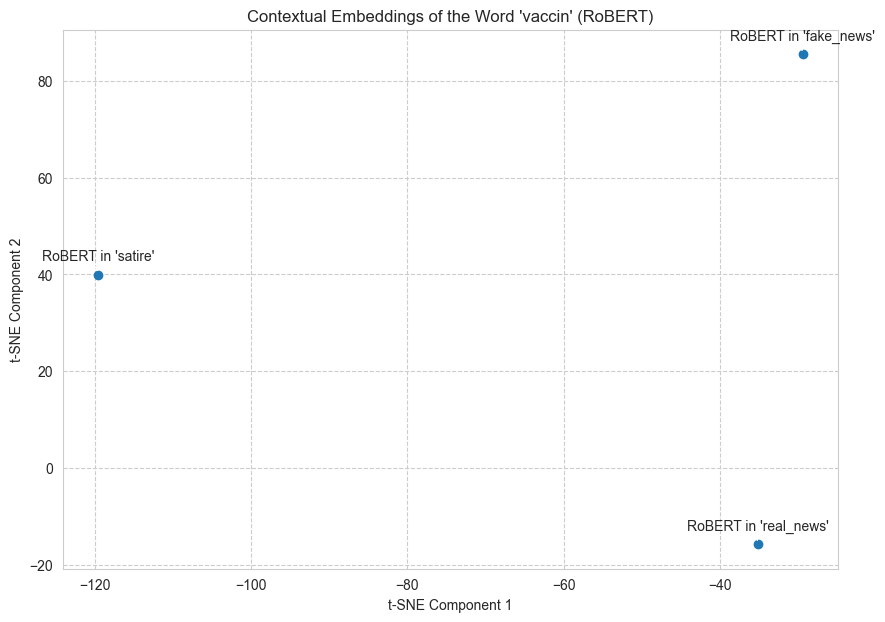

In [10]:
all_vectors_for_plot = []
all_labels_for_plot = []

for category, vector in robert_contextual_embeddings.items():
    all_vectors_for_plot.append(vector)
    all_labels_for_plot.append(f"RoBERT in '{category}'")

if len(all_vectors_for_plot) > 1:
    vectors_np = np.array(all_vectors_for_plot)
    
    print(f"\n--- Cosine Similarity Between RoBERT's '{TARGET_WORD}' Embeddings ---")
    categories = list(robert_contextual_embeddings.keys())
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            cat1 = categories[i]
            cat2 = categories[j]
            vec1 = robert_contextual_embeddings[cat1]
            vec2 = robert_contextual_embeddings[cat2]
            
            cos_sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            print(f"Similarity between '{cat1}' and '{cat2}' contexts: {cos_sim:.4f}")


    perplexity_value = max(1, len(vectors_np) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=1000)
    
    vectors_tsne = tsne.fit_transform(vectors_np)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
    
    for i, label in enumerate(all_labels_for_plot):
        plt.annotate(label, (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                     textcoords="offset points", xytext=(0, 10), ha='center',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1"))

    plt.title(f"Contextual Embeddings of the Word '{TARGET_WORD}' (RoBERT)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True, linestyle='--')
    plt.savefig(os.path.join(ROBERT_VISUALIZATION_DIR, f"tsne_{TARGET_WORD}_embeddings.png"))
    plt.show()
else:
    print("\nNot enough embeddings were extracted to perform an analysis.")

#### Compare RoBERT Contextual vs Word2Vec Static Embeddings

Truncating RoBERT embeddings from 768 to 300 dimensions for visualization...
Truncation complete.
Applying t-SNE to the combined 300D vectors...


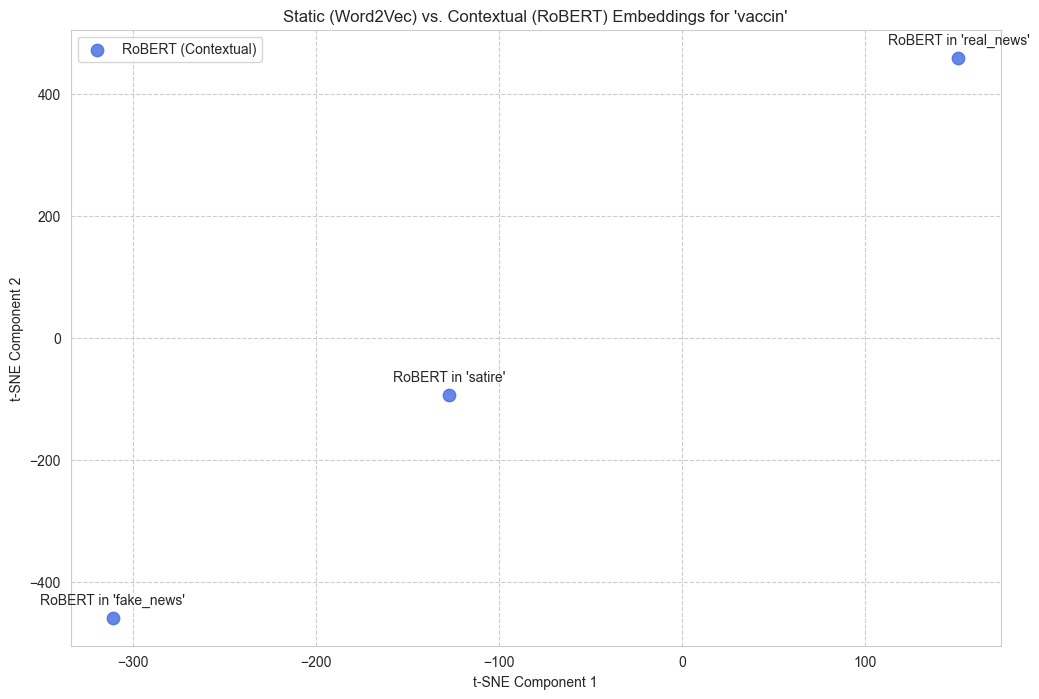

In [11]:
robert_vectors_768D = list(robert_contextual_embeddings.values())
robert_labels = [f"RoBERT in '{cat}'" for cat in robert_contextual_embeddings.keys()]

if not robert_vectors_768D:
    print("No RoBERT embeddings were extracted. Cannot perform analysis.")
else:
    print("Truncating RoBERT embeddings from 768 to 300 dimensions for visualization...")
    robert_vectors_300D = [vector[:300] for vector in robert_vectors_768D]
    print("Truncation complete.")

    all_vectors_for_plot = list(robert_vectors_300D)
    all_labels_for_plot = list(robert_labels)

    if word2vec_static_embedding is not None:
        all_vectors_for_plot.append(word2vec_static_embedding)
        all_labels_for_plot.append("Word2Vec (Static)")
    
    if len(all_vectors_for_plot) > 1:
        vectors_np = np.array(all_vectors_for_plot)
        
        perplexity_value = max(1, len(vectors_np) - 2) 
        if perplexity_value == 0: perplexity_value = 1
            
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=1000, init='pca')
        
        print("Applying t-SNE to the combined 300D vectors...")
        vectors_tsne = tsne.fit_transform(vectors_np)
        
        plt.figure(figsize=(12, 8))
        
        robert_color = 'royalblue'
        w2v_color = 'darkorange'
        
        for i, label in enumerate(all_labels_for_plot):
            if "RoBERT" in label:
                plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1], 
                            c=robert_color, alpha=0.8, s=80,
                            label="RoBERT (Contextual)" if "RoBERT" not in [l.split(" ")[0] for l in all_labels_for_plot[:i]] else "")
            else:
                plt.scatter(vectors_tsne[i, 0], vectors_tsne[i, 1], 
                            c=w2v_color, marker='*', s=250, edgecolors='black',
                            label="Word2Vec (Static)")

        for i, label in enumerate(all_labels_for_plot):
            plt.annotate(label, (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                         textcoords="offset points", xytext=(0, 10), ha='center')

        plt.title(f"Static (Word2Vec) vs. Contextual (RoBERT) Embeddings for '{TARGET_WORD}'")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.legend()
        plt.grid(True, linestyle='--')
        plt.savefig(os.path.join(ROBERT_VISUALIZATION_DIR, f"tsne_w2v_comparison_{TARGET_WORD}_embeddings.png"))
        plt.show()
    else:
        print("\nNot enough embeddings were extracted to perform a visualization.")

# TF-IDF

#### Load and Prepare Data for TF-IDF

In [83]:
try:
    print(f"Loading processed data from: {PROCESSED_DATA_PATH}")
    
    def parse_list_literal(x):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []

    df = pd.read_csv(PROCESSED_DATA_PATH, converters={'lemmas_filtered': parse_list_literal})

    if 'lemmas_filtered' in df.columns and not df['lemmas_filtered'].isnull().all():
        print("Preparing documents by joining lemmatized tokens into single strings...")
        
        prepared_documents = df['lemmas_filtered'].apply(
            lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else ''
        ).tolist()
        
        print(f"Successfully prepared {len(prepared_documents)} documents for TF-IDF vectorization.")
    else:
        print("Error: 'lemmas_filtered' column not found or is empty.")
        prepared_documents = None
except FileNotFoundError:
    print(f"Error: Processed data file not found at {PROCESSED_DATA_PATH}")
    prepared_documents = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    prepared_documents = None

Loading processed data from: C:\Users\Razvan\projects\university\romanian-fake-news-detection\data\processed\processed_NEW.csv
Preparing documents by joining lemmatized tokens into single strings...
Successfully prepared 4334 documents for TF-IDF vectorization.


#### Initialize and Save Files

In [84]:
if 'prepared_documents' in globals() and prepared_documents is not None:
    print("Initializing TfidfVectorizer...")
    
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.95,
        min_df=5,
        max_features=10000
    )

    print("Fitting the vectorizer and transforming the documents into a TF-IDF matrix...")
    tfidf_matrix = tfidf_vectorizer.fit_transform(prepared_documents)

    print(f"TF-IDF matrix created successfully.")
    print(f"Shape of the matrix: {tfidf_matrix.shape}")
    print(f"(Documents: {tfidf_matrix.shape[0]}, Vocabulary Size/Features: {tfidf_matrix.shape[1]})")
    
    try:
        print(f"Saving TF-IDF matrix to: {TFIDF_VECTORS_PATH}")
        save_npz(TFIDF_VECTORS_PATH, tfidf_matrix)
        print("Matrix saved successfully.")
    except Exception as e:
        print(f"Error saving TF-IDF matrix: {e}")
        
    try:
        print(f"Saving TF-IDF vectorizer object to: {TFIDF_VECTORIZER_PATH}")
        with open(TFIDF_VECTORIZER_PATH, 'wb') as f:
            pickle.dump(tfidf_vectorizer, f)
        print("Vectorizer object saved successfully.")
    except Exception as e:
        print(f"Error saving vectorizer object: {e}")
else:
    print("Prepared documents not available. Please run the previous cell successfully.")

Initializing TfidfVectorizer...
Fitting the vectorizer and transforming the documents into a TF-IDF matrix...
TF-IDF matrix created successfully.
Shape of the matrix: (4334, 10000)
(Documents: 4334, Vocabulary Size/Features: 10000)
Saving TF-IDF matrix to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\tfidf_vectors.npz
Matrix saved successfully.
Saving TF-IDF vectorizer object to: C:\Users\Razvan\projects\university\romanian-fake-news-detection\models_saved\embeddings\tfidf_vectorizer.pkl
Vectorizer object saved successfully.
